In [ ]:
from google.colab import files
files.upload() #upload kaggle.json

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"visionkumarreddy","key":"89e63a80b303b66fc21d89c25d488999"}'}

In [ ]:
!kaggle datasets download -d jboysen/mri-and-alzheimers

  0% 0.00/12.6k [00:00<?, ?B/s]
100% 12.6k/12.6k [00:00<00:00, 24.5MB/s]


In [ ]:
!unzip /content/mri-and-alzheimers.zip

Archive:  /content/mri-and-alzheimers.zip
  inflating: oasis_cross-sectional.csv  
  inflating: oasis_longitudinal.csv  


In [ ]:
import pandas as pd # used to load, manipulate the data and for one-hot encoding
import numpy as np # data manipulation
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import scale 
from sklearn.svm import SVC 
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, roc_curve, auc

In [ ]:
data = pd.read_csv("/content/oasis_longitudinal.csv")

In [ ]:
pd.set_option('display.max_columns', None) # will show the all columns with pandas dataframe
pd.set_option('display.max_rows', None) # will show the all rows with pandas dataframe

In [ ]:
data.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [ ]:
data.shape

(373, 15)

In [ ]:
data['M/F'] = [1 if each == "M" else 0 for each in data['M/F']]
data['Group'] = [1 if each == "Demented" or each == "Converted" else 0 for each in data['Group']]
# data['Group'] = data['Group'].replace(['Converted'], ['Demented']) # Target variable
# data['Group'] = data['Group'].replace(['Demented', 'Nondemented'], [1,0]) # Target variable
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    int64  
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    int64  
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(7), object(3)
memory usage: 43.8+ KB


In [ ]:
data.isnull().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

In [ ]:
median = data['MMSE'].median()
data['MMSE'].fillna(median, inplace=True)
data.isnull().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           0
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

In [ ]:
median = data['SES'].median()
data['SES'].fillna(median, inplace=True)
data.isnull().sum()

Subject ID    0
MRI ID        0
Group         0
Visit         0
MR Delay      0
M/F           0
Hand          0
Age           0
EDUC          0
SES           0
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
dtype: int64

## **Train-Test**

In [ ]:
y = data['Group'].values
X = data[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']]

In [ ]:
# by default test_size= 0.25
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size= 0.20, random_state=30)

df_ytrain = pd.DataFrame(y_trainval)
df_ytest = pd.DataFrame(y_test)

print('In Training Split:')
print(df_ytrain[0].value_counts())

print('\nIn Testing Split:')
print(df_ytest[0].value_counts())

In Training Split:
1    149
0    149
Name: 0, dtype: int64

In Testing Split:
0    41
1    34
Name: 0, dtype: int64


In [ ]:
# here StandardScaler() means z = (x - u) / s
scaler = StandardScaler().fit(X_trainval)
#scaler = MinMaxScaler().fit(X_trainval)
X_trainval_scaled = scaler.transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

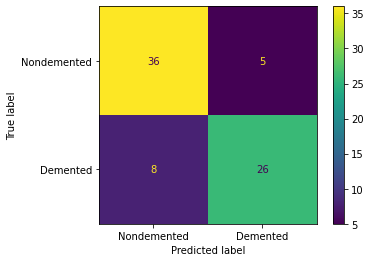

In [ ]:
clf_svm = SVC(random_state=30)
clf_svm.fit(X_trainval_scaled, y_trainval)

# for test there are 94 cases
plot_confusion_matrix(clf_svm, 
                      X_test_scaled, 
                      y_test, 
                      values_format='d', 
                      display_labels=['Nondemented', 'Demented'])

In [ ]:
train_score = 0
test_score = 0
test_recall = 0
test_auc = 0

train_score = clf_svm.score(X_trainval_scaled, y_trainval)
test_score = clf_svm.score(X_test_scaled, y_test)
y_predict = clf_svm.predict(X_test_scaled)

test_recall = recall_score(y_test, y_predict)
fpr, tpr, thresholds = roc_curve(y_test, y_predict)
test_auc = auc(fpr, tpr)


print("Train accuracy ", train_score)
print("Test accuracy ", test_score)
print("Test recall", test_recall)
print("Test AUC", test_auc)

Train accuracy  0.8355704697986577
Test accuracy  0.8266666666666667
Test recall 0.7647058823529411
Test AUC 0.8213773314203731
